In [1]:
import pandas as pd
import numpy as np
import pickle
import tensorflow as tf
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

2024-05-28 08:02:24.691986: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-28 08:02:24.692106: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-28 08:02:24.821679: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# load data frames
df_train = pd.read_csv('/kaggle/input/dataframes-bal/train_bal.csv')
df_val = pd.read_csv('/kaggle/input/dataframes-bal/val_bal.csv')
df_test = pd.read_csv('/kaggle/input/dataframes-bal/test_bal.csv')

# load visual embeddings
with open('/kaggle/input/v-emb-bal/v_embeds_train.pkl', 'rb') as f:
    v_embeds_train = pickle.load(f) 
    
with open('/kaggle/input/v-emb-bal/v_embeds_val.pkl', 'rb') as f:
    v_embeds_val = pickle.load(f) 
    
with open('/kaggle/input/v-emb-bal/v_embeds_test.pkl', 'rb') as f:
    v_embeds_test = pickle.load(f) 

In [3]:
print(len(v_embeds_train))
print(v_embeds_train[0].shape)
stacked_tensor = torch.stack(v_embeds_train, dim=0)

print(stacked_tensor.shape)

1602
torch.Size([100, 1024])
torch.Size([1602, 100, 1024])


In [4]:
# stack visual features 
X_train = torch.stack(v_embeds_train, dim=0).cpu().numpy()
X_val = torch.stack(v_embeds_val, dim=0).cpu().numpy()
X_test = torch.stack(v_embeds_test, dim=0).cpu().numpy()
print(X_train.shape, X_val.shape, X_test.shape)

(1602, 100, 1024) (89, 100, 1024) (89, 100, 1024)


In [5]:
# convert labels to numerical values
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_train['AUTHOR'])
y_val = label_encoder.transform(df_val['AUTHOR'])
y_test = label_encoder.transform(df_test['AUTHOR'])

painter_mapping = list(label_encoder.classes_) # get new label numbers and painters (for confusion matrix legend)
print(painter_mapping)

['CRANACH, Lucas the Elder', 'GIOTTO di Bondone', 'GOGH, Vincent van', 'GRECO, El', 'REMBRANDT Harmenszoon van Rijn', 'RUBENS, Peter Paul', 'TIEPOLO, Giovanni Battista', 'TIZIANO Vecellio', 'UNKNOWN MASTER, Italian', 'VERONESE, Paolo']


In [6]:
# define model using a simple MLP architecture with dropout regularization and batch normalization (Exp. 1)
def create_model():
    
    model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(100, 1024)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])
    
    optim = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=optim,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

results = [] # store results obtained by training model with 10 different random seeds
all_val_accuracies = [] # nested list of all validation accuracies for all random seeds

for seed in range(10):
    
    np.random.seed(seed) # set random seed
    tf.random.set_seed(seed)

    model = create_model()
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) # perform early stopping
    history = model.fit(X_train, y_train, epochs=15, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=0)
    
    all_val_accuracies.append(history.history['val_accuracy']) # store accuracies for all epochs of one random seed
    
    # evaluate on validation set
    val_loss, val_accuracy = model.evaluate(X_val, y_val)
    print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

    # evaluate on test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

    # get validation and test accuracy for every random seed
    results.append({'seed': seed, 'val_accuracy': val_accuracy, 'test_accuracy': test_accuracy})


# save results to CSV

results_df = pd.DataFrame(results)
results_df.to_csv('visual_results.csv', index=True)
print(results_df.head())

all_val_accuracies_df = pd.DataFrame(all_val_accuracies, 
                                     columns=[f'epoch {i+1}' for i in range(len(all_val_accuracies[0]))])

all_val_accuracies_df.insert(0, 'seed', [f'{i}' for i in range(len(all_val_accuracies))])
all_val_accuracies_df.to_csv('visual_all_val_accuracies.csv', index=True)
all_val_accuracies_df.head()

I0000 00:00:1716883381.825005     115 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716883381.840566     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716883386.653034     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3868 - loss: 1.6340  
Validation Loss: 1.6995527744293213, Validation Accuracy: 0.3595505654811859
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4339 - loss: 1.6573 
Test Loss: 1.6433719396591187, Test Accuracy: 0.43820226192474365


W0000 00:00:1716883401.684999     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716883406.117148     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4110 - loss: 1.6935  
Validation Loss: 1.6913707256317139, Validation Accuracy: 0.4157303273677826
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4508 - loss: 1.6822 
Test Loss: 1.637825608253479, Test Accuracy: 0.47191011905670166


W0000 00:00:1716883417.992595     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716883421.808269     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3807 - loss: 1.8181 
Validation Loss: 1.7964744567871094, Validation Accuracy: 0.37078651785850525
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4435 - loss: 1.6741 
Test Loss: 1.661405086517334, Test Accuracy: 0.449438214302063


W0000 00:00:1716883432.998501     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716883436.897803     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3802 - loss: 1.7850  
Validation Loss: 1.721847414970398, Validation Accuracy: 0.3932584226131439
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4032 - loss: 1.7727 
Test Loss: 1.7285605669021606, Test Accuracy: 0.4157303273677826


W0000 00:00:1716883451.004440     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716883454.832151     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3175 - loss: 1.9434  
Validation Loss: 1.967993974685669, Validation Accuracy: 0.31460675597190857
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3477 - loss: 1.7024 
Test Loss: 1.6709294319152832, Test Accuracy: 0.3595505654811859


W0000 00:00:1716883466.889040     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716883470.742598     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3941 - loss: 1.7791  
Validation Loss: 1.7551418542861938, Validation Accuracy: 0.3820224702358246
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3646 - loss: 1.7960 
Test Loss: 1.7832756042480469, Test Accuracy: 0.3932584226131439


W0000 00:00:1716883484.034563     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716883487.750775     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4669 - loss: 1.6467  
Validation Loss: 1.6696547269821167, Validation Accuracy: 0.449438214302063
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4010 - loss: 1.7223 
Test Loss: 1.656693696975708, Test Accuracy: 0.42696627974510193


W0000 00:00:1716883501.332090     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716883505.190246     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4188 - loss: 1.7913  
Validation Loss: 1.790723443031311, Validation Accuracy: 0.4157303273677826
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3819 - loss: 1.6378 
Test Loss: 1.6296038627624512, Test Accuracy: 0.40449437499046326


W0000 00:00:1716883516.266160     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716883520.150458     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3270 - loss: 2.0374  
Validation Loss: 2.0236291885375977, Validation Accuracy: 0.3258427083492279
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4842 - loss: 1.7282 
Test Loss: 1.7322036027908325, Test Accuracy: 0.4606741666793823


W0000 00:00:1716883531.369337     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716883535.169398     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4015 - loss: 1.7058  
Validation Loss: 1.6857655048370361, Validation Accuracy: 0.40449437499046326
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4552 - loss: 1.5328 
Test Loss: 1.5182456970214844, Test Accuracy: 0.449438214302063
   seed  val_accuracy  test_accuracy
0     0      0.359551       0.438202
1     1      0.415730       0.471910
2     2      0.370787       0.449438
3     3      0.393258       0.415730
4     4      0.314607       0.359551


,seed,epoch 1,epoch 2,epoch 3,epoch 4,epoch 5,epoch 6,epoch 7,epoch 8,epoch 9,epoch 10,epoch 11,epoch 12,epoch 13,epoch 14,epoch 15
0,0,0.146067,0.202247,0.235955,0.269663,0.258427,0.235955,0.314607,0.382022,0.314607,0.404494,0.348315,0.359551,0.314607,0.348315,0.393258
1,1,0.247191,0.269663,0.247191,0.292135,0.348315,0.325843,0.325843,0.415730,0.393258,0.337079,0.337079,NaN,NaN,NaN,NaN
2,2,0.168539,0.168539,0.269663,0.325843,0.382022,0.370787,0.292135,0.393258,0.337079,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0.134831,0.224719,0.303371,0.280899,0.258427,0.292135,0.280899,0.325843,0.303371,0.235955,0.292135,0.393258,0.314607,0.314607,0.348315
4,4,0.168539,0.213483,0.213483,0.213483,0.280899,0.314607,0.314607,0.314607,0.337079,0.337079,NaN,NaN,NaN,NaN,NaN


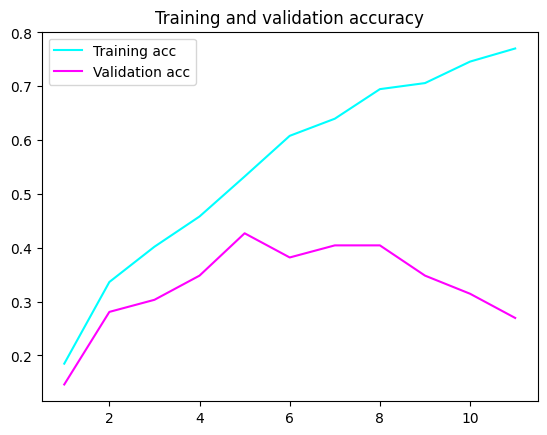

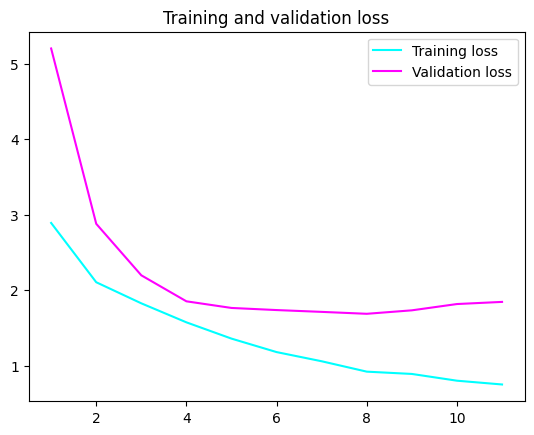

In [7]:
# plot training and validation accuracy and loss (seed = 9)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'cyan', label='Training acc')
plt.plot(epochs, val_acc, 'magenta', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()


plt.plot(epochs, loss, 'cyan', label='Training loss')
plt.plot(epochs, val_loss, 'magenta', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

The model is clearly overfitting (plateau in validation accuracy and loss while the training loss decreases to 0 and the training accuracy reaches 1.0). The data size is relatively small and model might be too complex for this amount of data.

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step

W0000 00:00:1716883602.600869     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step


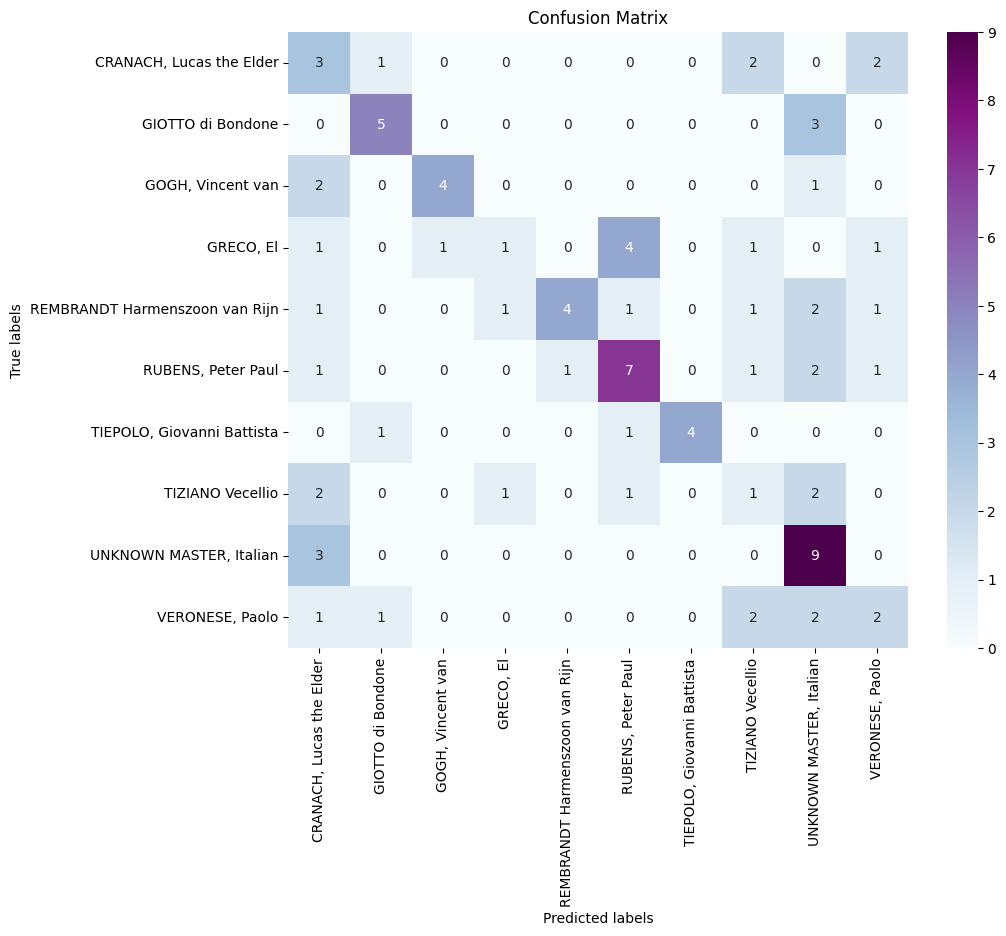

In [8]:
# predictions on test set (Test Accuracy: 0.37078651785850525, random seed = 9)
y_pred = model.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

conf_mat = confusion_matrix(y_test, y_pred_bool)

class_names = painter_mapping

# plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='BuPu', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()